## Regression of a function with a neural network in 1D

### Exercise 2:
Modify the code to solve the differential equation
$$
\frac{dy}{dx} = -y(x);\; y(0) = 1
$$
using
 a) finite difference method to calculate derivatives.
 b) automatic differentiation to calculate derivatives. 
Add boundary conditions as another loss function.

### Exercise 3:
Solve the same differential equation using
$$
y = 1+x\,\mathrm{Net}(x)
$$
This way we do not need to add another loss function.

### Exercise 4:
Solve the differential equation
$$
\frac{dy}{dx} = -y\,(x-1);\; y(0) = 1
$$
Run the code twice to see whether the results are the same. The results for two successive runs may not be the same. Explain why this is the case.

0   0.08983156085014343
10   0.00016992171003948897
20   1.390014494973002e-05
30   1.3500145541911479e-05
40   1.3303911146067549e-05
50   1.3229244359536096e-05
60   1.3263876098790206e-05
70   1.3217366358730942e-05
80   1.3102910088491626e-05
90   1.3072761248622555e-05
100   1.305302885157289e-05
110   1.3097309420118108e-05
120   1.3006810149818193e-05
130   1.295522724831244e-05
140   1.2990116374567151e-05
150   1.2969810086360667e-05
160   1.298730967391748e-05
170   1.305870773649076e-05
180   1.2886031981906854e-05
190   1.2936873645230662e-05
200   1.2867645637015812e-05
210   1.2871790204371791e-05
220   1.2798279385606293e-05
230   1.281673030462116e-05
240   1.2835286725021433e-05
250   1.285711277887458e-05
260   1.2927054740430322e-05
270   1.275399154110346e-05
280   1.2754009730997495e-05
290   1.2724262887786608e-05
300   1.2715143384411931e-05
310   1.263579360966105e-05
320   1.2711600902548525e-05
330   1.2761587640852667e-05
340   1.2560130926431157e-05
350   1.

c:\Users\jakob\miniconda3\envs\torchenv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Final loss: 0.2890201210975647


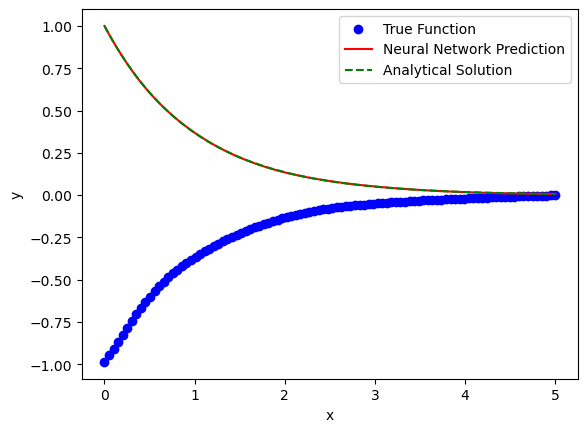

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Generate synthetic data
x = torch.linspace(-0, 5, 100)
x.requires_grad = True

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        # x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.LBFGS(net.parameters(), lr=0.02)


def true_function(x, net):
    # dy/dx + y
    y = net(x)
    if x.grad is None:
        y.backward(torch.ones_like(x).unsqueeze(-1), retain_graph=True)
    dydx = x.grad.squeeze(-1)
    # h = 0.001
    # dydx = (net(x + h) - y) / h
    return dydx

# Training loop
for i in range(500):
    def closure():
        optimizer.zero_grad()
        outputs = net(x.unsqueeze(-1))
        y = -true_function(x.unsqueeze(-1), net)
        loss = criterion(outputs, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.
        loss.backward()
        return loss

    loss=optimizer.step(closure)
    if(i%10==0):
      print(i," ",loss.item())
# Print the final loss
      
y = true_function(x.unsqueeze(-1), net).detach()

with torch.no_grad():
    outputs = net(x.unsqueeze(-1))
    loss = criterion(outputs, y.unsqueeze(-1))

print(f'Final loss: {loss.item()}')

x = x.detach().numpy()
# Plot the results
plt.scatter(x, y.detach().numpy(), label='True Function', color='blue')
plt.plot(x, outputs.numpy(), label='Neural Network Prediction', color='red')
plt.plot(x, np.exp(-x), '--', label='Analytical Solution', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()